<a href="https://colab.research.google.com/github/gachet/mis-colabs/blob/master/Kaggle_Hall_of_Fame_1_Ranking_Kernel_Ep_1_COVID_19_Analysis%2C_Viz%2C_Prediction_%26_Comparisons_by_SRK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Disclaimer: Kaggle Spotlight is NOT the author of this kernel. For the original source of work, please refer to the link in video description.


* Source: COVID-19 - Analysis, Viz, Prediction & Comparisons
* Author: SRK
* Link: https://www.kaggle.com/kagglehof/covid-19-analysis-viz-prediction-comparisons/edit

In [0]:
! pip install calmap
!pip install plotly==4.5.2

In [0]:
# essential libraries
import json, random
from urllib.request import urlopen

# storing and analysis
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
import calmap, folium

# colors
cnf = '#393e46' # confirmed - grey
dth = '#ff2e63' # death - red
rec = '#21bf73' # recovered - cyan
act = '#fe9801' # active case - yellow

# converter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# html embedding
from IPython.display import Javascript
from IPython.core.display import display
from IPython.core.display import HTML


# Dataset

In [0]:
# import dataset
full_table = pd.read_csv('covid_19_clean_complete.csv', parse_dates=['Date'])
full_table.head()

Province/State Country/Region      Lat  ...  Confirmed Deaths  Recovered
0            NaN       Thailand  15.0000  ...          2      0          0
1            NaN          Japan  36.0000  ...          2      0          0
2            NaN      Singapore   1.2833  ...          0      0          0
3            NaN          Nepal  28.1667  ...          0      0          0
4            NaN       Malaysia   2.5000  ...          0      0          0

[5 rows x 8 columns]

In [0]:
# dataframe info
full_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11960 entries, 0 to 11959
Data columns (total 8 columns):
Province/State    5876 non-null object
Country/Region    11960 non-null object
Lat               11960 non-null float64
Long              11960 non-null float64
Date              11960 non-null datetime64[ns]
Confirmed         11960 non-null int64
Deaths            11960 non-null int64
Recovered         11960 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 747.6+ KB


In [0]:
# checking for missing values
full_table.isna().sum()

Province/State    6084
Country/Region       0
Lat                  0
Long                 0
Date                 0
Confirmed            0
Deaths               0
Recovered            0
dtype: int64

Cleaning data

In [0]:
# cases
cases = ['Confirmed', 'Deaths', 'Recovered', 'Active']

# Active cases = confirmed - deadths - recovered
full_table['Active'] = full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']

# replacing Mainland China with just China
full_table['Country/Region'] = full_table['Country/Region'].replace('Mainland China', 'China')

# filling missing values
full_table[['Province/State']] = full_table[['Province/State']].fillna('')
full_table[cases] = full_table[cases].fillna(0)

Derived Tables

In [0]:
# cases in the ships
ship = full_table[full_table['Province/State'].str.contains('Grand Princess') | full_table['Country/Region'].str.contains('Cruise Ship')]

# China and the row
china = full_table[full_table['Country/Region']=='China']
row = full_table[full_table['Country/Region'] != 'China']

# latest
full_latest = full_table[full_table['Date'] == max(full_table['Date'])].reset_index()
china_latest = full_latest[full_latest['Country/Region'] == 'China']
row_latest = full_latest[full_latest['Country/Region'] != 'China']

# latest condensed
full_latest_grouped = full_latest.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
china_latest_grouped = china_latest.groupby('Province/State')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
row_latest_grouped = row_latest.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()

# Latest Data

Latest complete data

In [0]:
temp = full_table.groupby(['Country/Region', 'Province/State'])['Confirmed', 'Deaths', 'Recovered', 'Active'].max()
temp.style.background_gradient(cmap='Reds')

Latest condensed data


In [0]:
temp = full_table.groupby('Date')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
temp = temp[temp['Date']==max(temp['Date'])].reset_index(drop=True)
temp.style.background_gradient(cmap='Pastel1')

In [0]:
tm = temp.melt(id_vars='Date', value_vars=['Active', 'Deaths', 'Recovered'])
fig = px.treemap(tm, path=["variable"], values='value', height=400, width=600, color_discrete_sequence=[rec, act, dth])
fig.show()

# Country-wise data

In each country

In [0]:
temp_f = full_latest_grouped.sort_values(by='Confirmed', ascending=False)
temp_f = temp_f.reset_index(drop=True)
temp_f.style.background_gradient(cmap='Reds')

Countries with deaths reported

In [0]:
temp_flg = temp_f[temp_f['Deaths']>0][['Country/Region', 'Deaths']]
temp_flg.sort_values('Deaths', ascending=False).reset_index(drop=True).style.background_gradient(cmap='Reds')

Contries with no cases recovered

In [0]:
temp = temp_f[temp_f['Recovered']==0][['Country/Region', 'Confirmed', 'Deaths', 'Recovered']]
temp.reset_index(drop=True).style.background_gradient(cmap='Reds')

Countries with all cases died

In [0]:
temp = row_latest_grouped[row_latest_grouped['Confirmed']==row_latest_grouped['Deaths']]
temp = temp[['Country/Region', 'Confirmed', 'Deaths']]
temp = temp.sort_values('Confirmed', ascending=False)
temp = temp.reset_index(drop=True)
temp.style.background_gradient(cmap='Reds')

Countries with all the cases recovered

In [0]:
temp = row_latest_grouped[row_latest_grouped['Confirmed']==row_latest_grouped['Recovered']]
temp = temp[['Country/Region', 'Confirmed', 'Recovered']]
temp = temp.sort_values('Confirmed', ascending=False)
temp = temp.reset_index(drop=True)
temp.style.background_gradient(cmap='Greens')

Countries with no affected case anymore

In [0]:
temp = row_latest_grouped[row_latest_grouped['Confirmed']==row_latest_grouped['Deaths']+row_latest_grouped['Recovered']]
temp = temp[['Country/Region', 'Confirmed', 'Deaths', 'Recovered']]
temp = temp.sort_values('Confirmed', ascending=False)
temp = temp.reset_index(drop=True)
temp.style.background_gradient(cmap='Greens')

# Chinese province-wise data

In each provinces

In [0]:
temp_f = china_latest_grouped[['Province/State', 'Confirmed', 'Deaths', 'Recovered']]
temp_f = temp_f.sort_values(by='Confirmed', ascending=False)
temp_f = temp_f.reset_index(drop=False)
temp_f.style.background_gradient(cmap='Pastel1_r')

Province with no cases recovered

In [0]:
temp = china_latest_grouped[china_latest_grouped['Recovered']==0]
temp = temp[['Province/State', 'Confirmed', 'Deaths', 'Recovered']]
temp = temp.sort_values('Confirmed', ascending=False)
temp = temp.reset_index(drop=True)
temp.style.background_gradient(cmap='Pastel1_r')

Provinces with all cases died

In [0]:
temp = china_latest_grouped[china_latest_grouped['Deaths']==china_latest_grouped['Confirmed']]
temp = temp[['Province/State', 'Confirmed', 'Deaths', 'Recovered']]
temp = temp.sort_values('Confirmed', ascending=False)
temp = temp.reset_index(drop=True)
temp.style.background_gradient(cmap='Pastel1_r')

Provinces with all cases recovered

In [0]:
temp = china_latest_grouped[china_latest_grouped['Confirmed']==china_latest_grouped['Recovered']]
temp = temp[['Province/State', 'Confirmed', 'Deaths', 'Recovered']]
temp = temp.sort_values('Confirmed', ascending=False)
temp = temp.reset_index(drop=True)
temp.style.background_gradient(cmap='Greens')

Provinces with no affected cases anymore

In [0]:
temp = china_latest_grouped[china_latest_grouped['Confirmed']==china_latest_grouped['Recovered']+china_latest_grouped['Deaths']]
temp = temp[['Province/State', 'Confirmed', 'Deaths', 'Recovered']]
temp = temp.sort_values('Confirmed', ascending=False)
temp = temp.reset_index(drop=True)
temp.style.background_gradient(cmap='Greens')

# Maps

Across the world

In [0]:
# World Wide

m = folium.Map(location=[0,0], tiles='cartodbpositron', min_zoom=1, max_zoom=4, zoom_start=1)

for i in range(0, len(full_latest)):
  folium.Circle(
      location=[full_latest.iloc[i]['Lat'], full_latest.iloc[i]['Long']],
      color='crimson',
      tooltip= '<li><bold>Country : ' + str(full_latest.iloc[i]['Country/Region']) +
               '<li><bold>Province : ' + str(full_latest.iloc[i]['Province/State']) +
               '<li><bold>Confirmed : ' + str(full_latest.iloc[i]['Confirmed']) +
               '<li><bold>Deaths : ' + str(full_latest.iloc[i]['Deaths']) +
               '<li><bold>Recovered : ' + str(full_latest.iloc[i]['Recovered']),
      radius=int(full_latest.iloc[i]['Confirmed']) ** 1.1).add_to(m)

m

In [0]:
# Confirmed

fig = px.choropleth(full_latest_grouped, locations="Country/Region",
                    locationmode='country names', color='Confirmed',
                    hover_name='Country/Region', range_color=[1,7000],
                    color_continuous_scale='aggrnyl',
                    title='Countries with confirmed cases')
fig.update(layout_coloraxis_showscale=False)
fig.show()

In [0]:
# Deaths

fig = px.choropleth(full_latest_grouped[full_latest_grouped['Deaths']>0],
                    locations="Country/Region",
                    locationmode='country names', color='Deaths',
                    hover_name='Country/Region', range_color=[1,50],
                    color_continuous_scale='agsunset',
                    title='Countries with deaths reported')
fig.update(layout_coloraxis_showscale=False)
fig.show()

In [0]:
formated_gdf = full_table.groupby(['Date','Country/Region'])['Confirmed','Deaths','Recovered'].max()
formated_gdf = formated_gdf.reset_index()
formated_gdf['Date'] = pd.to_datetime(formated_gdf['Date'])
formated_gdf['Date'] = formated_gdf['Date'].dt.strftime('%m/%d/%Y')
formated_gdf['size'] = formated_gdf['Confirmed'].pow(0.3)

fig = px.scatter_geo(formated_gdf, locations='Country/Region', locationmode='country names',
                     color = "Confirmed", size='size', hover_name='Country/Region',
                     range_color=[0,max(formated_gdf['Confirmed'])+2],
                     projection='natural earth', animation_frame='Date',
                     title='Spread over time')
fig.update(layout_coloraxis_showscale=False)
fig.show()

# Ships


In [0]:
# Latest cases from the ships
temp = ship[ship['Date']==max(ship['Date'])]
temp = temp[['Province/State','Confirmed','Deaths','Recovered']].reset_index(drop=True)
temp.style.background_gradient(cmap='Pastel1_r')

In [0]:
temp = ship[ship['Date']==max(ship['Date'])]

m = folium.Map(location=[0,0], tiles='cartodbpositron', min_zoom=1, max_zoom=4, zoom_start=1)

for i in range(0, len(temp)):
  folium.Circle(
      location=[temp.iloc[i]['Lat'], temp.iloc[i]['Long']],
      color='crimson',
      tooltip= '<li><bold>Country : ' + str(temp.iloc[i]['Country/Region']) +
               '<li><bold>Province : ' + str(temp.iloc[i]['Province/State']) +
               '<li><bold>Confirmed : ' + str(temp.iloc[i]['Confirmed']) +
               '<li><bold>Deaths : ' + str(temp.iloc[i]['Deaths']) +
               '<li><bold>Recovered : ' + str(temp.iloc[i]['Recovered']),
      radius=100000).add_to(m)

m

## Cases over time

In [0]:
temp = full_table.groupby('Date')['Recovered', 'Deaths', 'Active'].sum().reset_index()
temp = temp.melt(id_vars="Date", value_vars=['Recovered', 'Deaths', 'Active'],
                 var_name='Case', value_name='Count')
temp.head()

fig = px.area(temp, x="Date", y="Count", color='Case',
             title='Cases over time', color_discrete_sequence = [rec, dth, act])
fig.show()

# Recovery and mortality rate over time

In [0]:
temp = full_table.groupby('Date').sum().reset_index()

# adding two more columns
temp['No. of Deaths to 100 Confirmed Cases'] = round(temp['Deaths']/temp['Confirmed'], 3) * 100
temp['No. of Recovered to 100 Confirmed Cases'] = round(temp['Recovered']/temp['Confirmed'], 3) * 100

temp = temp.melt(id_vars='Date', value_vars=['No. of Deaths to 100 Confirmed Cases', 'No. of Recovered to 100 Confirmed Cases'],
                 var_name = 'Ratio', value_name='Value')

fig=px.line(temp, x='Date', y='Value', color='Ratio', log_y=True, title='Recovery and Mortality Rate Over the Time',
            color_discrete_sequence=[dth,rec])

fig.show()

# Number of places to which COVID-19 spreads

In [0]:
c_spread = china[china['Confirmed']!=0].groupby('Date')['Province/State'].unique().apply(len)
c_spread = pd.DataFrame(c_spread).reset_index()

fig = px.line(c_spread, x='Date', y='Province/State', text='Province/State', title='Number of Provinces/States/Regions of China to which COVID-19 Spread Over the Time',
              color_discrete_sequence=[cnf,dth,rec])

fig.update_traces(textposition='top center')
fig.show()



In [0]:
spread = full_table[full_table['Confirmed']!=0].groupby('Date')['Country/Region'].unique().apply(len)
spread = pd.DataFrame(spread).reset_index()

fig = px.line(spread, x='Date', y='Country/Region', text='Country/Region',
              title='Number of Countries/Regions to which COVID-19 spread over the time',
             color_discrete_sequence=[cnf,dth, rec])
fig.update_traces(textposition='top center')
fig.show()

# Top 20 Countries

In [0]:
flg = full_latest_grouped
flg.head()

Country/Region  Confirmed  Deaths  Recovered  Active
0          Afghanistan          7       0          0       7
1              Albania         33       1          0      32
2              Algeria         26       2          8      16
3              Andorra          1       0          0       1
4  Antigua and Barbuda          1       0          0       1

In [0]:
fig = px.bar(flg.sort_values('Confirmed',ascending=False).head(20).sort_values('Confirmed', ascending=True),
             x="Confirmed", y="Country/Region", title="Confirmed Cases", text="Confirmed", orientation='h',
             width=700,height=700, range_x = [0, max(flg['Confirmed'])+10000])

fig.update_traces(marker_color='#46cdcf', opacity=0.8, textposition='outside')
fig.show()

In [0]:
fig = px.bar(flg.sort_values('Deaths',ascending=False).head(20).sort_values('Deaths', ascending=True),
             x="Deaths", y="Country/Region", title="Deaths", text="Deaths", orientation='h',
             width=700,height=700, range_x = [0, max(flg['Deaths'])+10000])

fig.update_traces(marker_color=dth, opacity=0.8, textposition='outside')
fig.show()

In [0]:
fig = px.bar(flg.sort_values('Recovered',ascending=False).head(20).sort_values('Recovered', ascending=True),
             x="Recovered", y="Country/Region", title="Recovered", text="Recovered", orientation='h',
             width=700,height=700, range_x = [0, max(flg['Recovered'])+10000])

fig.update_traces(marker_color=rec, opacity=0.8, textposition='outside')
fig.show()

In [0]:
flg['Mortality Rate'] = round((flg['Deaths']/flg['Confirmed'])*100,2)
temp = flg[flg['Confirmed'] > 100] # only countries with more than 100 cases are considered
temp = temp.sort_values('Mortality Rate', ascending=False)

fig = px.bar(temp.sort_values('Mortality Rate', ascending=False).head(15).sort_values('Mortality Rate', ascending=True),
             x='Mortality Rate', y='Country/Region', text='Mortality Rate', orientation='h', width=700, height=600,
             range_x = [0,10], title='Number of Deaths Per 100 Confirmed Cases')

fig.update_traces(marker_color='#00a8cc', opacity=0.6, textposition='outside')
fig.show()

In [0]:
# load population dataset
pop_clean_data = pd.read_csv('population_clean.csv')

# select only the latest data
pop = pop_clean_data.loc[:,['Country Name', '2018']]

# substitute for missing values
cols = ['French Guiana', 'Martinique', 'Palestine' , 'Republic of Ireland', 'Saint Barthelemy', 'Taiwan', 'Vatican City']
pops = [290691, 376480, 4750000, 4920455, 7122, 23476640, 1000]
for c, p in zip(cols, pops):
    temp.loc[temp['Country/Region']== c, 'Population'] = p

# replace country names 
name = {
    'Egypt, Arab Rep.': 'Egypt',
    'Hong Kong SAR, China': 'Hong Kong',
    'Iran, Islamic Rep.': 'Iran (Islamic Republic of)',
    'Macao SAR, China': 'Macau',
    'Hong Kong SAR': 'Hong Kong',
    'Russian Federation': 'Russia',
    'Slovak Republic': 'Slovakia',
    'Korea, Rep.': 'Republic of Korea',
    'United Kingdom': 'UK',
    'United States': 'US' }
pop.loc[:, 'Country Name'] = pop.loc[: 'Country Name'].replace(name)

# merge dataframes
temp = pd.merge(full_latest_grouped, pop, how='left', right_on='Country Name', left_on='Country/Region')
# print(temp[temp['Country Name'].isna()])

temp = temp[['Country/Region', 'Confirmed', 'Deaths', 'Recovered', 'Active', '2018']]
temp.columns = ['Country/Region', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Population']
    
# calculate Confirmed/Population
temp['Confirmed Per Million People'] = round(temp['Confirmed']/temp['Population']*1000000, 2)

# countries with population greater that 1 million only
temp = temp[temp['Population']>1000000].sort_values('Confirmed Per Million People', ascending=False).reset_index(drop=True)

fig = px.bar(temp.head(20).sort_values('Confirmed Per Million People', ascending=True),
x='Confirmed Per Million People', y='Country/Region', orientation='h', width=700, height=700, text='Confirmed Per Million People',
title='Confirmed cases Per Million People', range_x=[0,max(temp['Confirmed Per Million People'])+40])
fig.update_traces(textposition='outside', marker_color='#2a7886', opacity=0.7)
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

ERROR! Session/line number was not unique in database. History logging moved to new session 60


In [0]:
temp = full_table.groupby(['Country/Region', 'Date'])['Confirmed', 'Deaths', 'Recovered'].sum()
temp = temp.reset_index()

fig = px.bar(temp, x='Date', y='Confirmed', color='Country/Region', orientation='v', height=600, title='Confirmed', color_discrete_sequence=px.colors.cyclical.mygbm)
fig.show()

In [0]:
temp = full_table.groupby(['Country/Region','Date',])['Confirmed', 'Deaths', 'Recovered']
temp = temp.sum().diff().reset_index()
mask = temp['Country/Region'] != temp['Country/Region'].shift(1)

temp.loc[mask, 'Confirmed'] = np.nan
temp.loc[mask, 'Deaths'] = np.nan
temp.loc[mask, 'Recovered'] = np.nan

fig = px.bar(temp, x='Date', y='Confirmed', color='Country/Region', title='New cases')
fig.show()

In [0]:
HTML('''<div class="flourish-embed flourish-bar-chart-race" data-src="visualisation/1571387"><script src="https://public.flourish.studio/resources/embed.js"></script></div>''')

In [0]:
temp = full_table.groupby(['Date', 'Country/Region'])['Confirmed'].sum().reset_index().sort_values('Confirmed', ascending=False)

px.line(temp, x='Date', y='Confirmed', color='Country/Region', title='Cases Spread', height=600)

In [0]:
fig = px.scatter(full_latest_grouped.sort_values('Deaths', ascending=False).iloc[:20,:],
                 x='Confirmed', y='Deaths', color='Country/Region',
                 text='Country/Region', log_x=True, log_y=True, title='Deaths vs Confirmed')
fig.update_traces(textposition='top center')
fig.show()

# Composition of cases

In [0]:
fig = px.treemap(full_latest.sort_values(by='Confirmed', ascending=False).reset_index(drop=True),
                 path=["Country/Region", "Province/State"], values="Confirmed", height=700,
                 title='Number of Confirmed Cases', color_discrete_sequence=px.colors.qualitative.Prism)
fig.data[0].textinfo='label+text+value'
fig.show()

# Epidemic Span

Note: in the graph, last day is shown as one day after the last time a new confirmed cases reported in the Country/Region

In [0]:
# first date
# -------
first_date = full_table[full_table['Confirmed']>0]
first_date = first_date.groupby('Country/Region')['Date'].agg(['min']).reset_index()
first_date.head()

Country/Region        min
0          Afghanistan 2020-02-24
1              Albania 2020-03-09
2              Algeria 2020-02-25
3              Andorra 2020-03-02
4  Antigua and Barbuda 2020-03-13

In [0]:
from datetime import timedelta
# last date
# -------
last_date = full_table.groupby(['Country/Region','Date',])['Confirmed', 'Deaths', 'Recovered']
last_date = last_date.sum().diff().reset_index()

mask = last_date['Country/Region'] != last_date['Country/Region'].shift(1)
last_date.loc[mask, 'Confirmed'] = np.nan
last_date.loc[mask, 'Deaths'] = np.nan
last_date.loc[mask, 'Recovered'] = np.nan

last_date = last_date[last_date['Confirmed']>0]
last_date = last_date.groupby('Country/Region')['Date'].agg(['max']).reset_index()
last_date.head()

Country/Region        max
0          Afghanistan 2020-03-11
1              Albania 2020-03-13
2              Algeria 2020-03-13
3              Andorra 2020-03-02
4  Antigua and Barbuda 2020-03-13

In [0]:
# first_last
# ------------
first_last = pd.concat([first_date, last_date[['max']]], axis=1)

# added 1 more day, which will show the next day as the day on which last case appeared
first_last['max'] = first_last['max'] + timedelta(days=1)

# number of days
first_last['Days'] = first_last['max'] - first_last['min']

# task column as country
first_last['Task'] = first_last['Country/Region']

# rename columns
first_last.columns = ['Country/Region', 'Start', 'Finish', 'Days', 'Task']

# sort by number of days
first_last = first_last.sort_values('Days')
first_last.head()


Country/Region      Start     Finish   Days           Task
51         Guyana 2020-03-12 2020-03-13 1 days         Guyana
31  Cote d'Ivoire 2020-03-11 2020-03-12 1 days  Cote d'Ivoire
84          Nepal 2020-01-25 2020-01-26 1 days          Nepal
82       Mongolia 2020-03-10 2020-03-11 1 days       Mongolia
42       Ethiopia 2020-03-13 2020-03-14 1 days       Ethiopia

In [0]:
# visualization
# -------------

# produce random colors
clr = ['#'+''.join([random.choice('0123456789ABC') for j in range(6)]) for i in range(len(first_last))]

# plot
fig = ff.create_gantt(first_last, index_col='Country/Region', colors=clr, show_colorbar=False, bar_width=0.2, showgrid_x=True,
                      showgrid_y=True, height=1600, title=('Gantt Chart'))

fig.show()

ERROR! Session/line number was not unique in database. History logging moved to new session 61


# China vs Rest of World

In [0]:
# in China
temp = china.groupby('Date')['Confirmed', 'Deaths', 'Recovered'].sum().diff()
temp = temp.reset_index()
temp = temp.melt(id_vars='Date', value_vars=['Confirmed', 'Deaths', 'Recovered'])

fig = px.bar(temp, x='Date', y='value', color='variable', title='In China', color_discrete_sequence=[cnf,dth,rec])
fig.update_layout(barmode='group')
fig.show()

In [0]:
# in rest of world
temp = row.groupby('Date')['Confirmed', 'Deaths', 'Recovered'].sum().diff()
temp = temp.reset_index()
temp = temp.melt(id_vars='Date', value_vars=['Confirmed', 'Deaths', 'Recovered'])

fig = px.bar(temp, x='Date', y='value', color='variable', title='Outside China', color_discrete_sequence=[cnf,dth,rec])
fig.update_layout(barmode='group')
fig.show()

In [0]:
def from_china_or_not(row):
  if row['Country/Region'] == 'China':
    return 'From China'
  else:
    return 'Outside China'


temp = full_table.copy()
temp['Region'] = temp.apply(from_china_or_not, axis=1)
temp = temp.groupby(['Region','Date'])['Confirmed','Deaths','Recovered']
temp = temp.sum().diff().reset_index()
mask = temp['Region'] != temp['Region'].shift(1)
temp.loc[mask,'Confirmed'] = np.nan
temp.loc[mask,'Deaths'] = np.nan
temp.loc[mask,'Recovered'] = np.nan

fig = px.bar(temp, x='Date', y='Confirmed', color='Region', barmode='group',
             text='Confirmed', title='Confirmed', color_discrete_sequence=[cnf,dth,rec])
fig.update_traces(textposition='outside')
fig.show()

In [0]:
fig = px.bar(temp, x='Date', y='Deaths', color='Region', barmode='group',
             text='Deaths', title='Deaths', color_discrete_sequence=[cnf,dth,rec])
fig.update_traces(textposition='outside')
fig.update_traces(textangle=-90)
fig.show()

In [0]:
gdf = full_table.groupby(['Date','Country/Region'])['Confirmed', 'Deaths', 'Recovered'].max()
gdf = gdf.reset_index()

temp = gdf[gdf['Country/Region']=='China'].reset_index()
temp = temp.melt(id_vars='Date', value_vars=['Confirmed', 'Deaths', 'Recovered'],
                 var_name='Case', value_name='Count')

fig = px.bar(temp, x='Date', y='Count', color='Case', facet_col='Case', title='China', color_discrete_sequence=[cnf,dth,rec])
fig.show()

# Hubei - China - World

In [0]:
def location(row):
  if row['Country/Region'] == 'China':
    if row['Province/State'] =='Hubei':
      return 'Hubei'
    else:
      return 'Other Chinese Provinces'
  else:
    return 'Rest of the World'

temp = full_table.copy()
temp['Region'] = temp.apply(location,axis=1)
temp['Date'] = temp['Date'].dt.strftime('%Y-%m-d')
temp = temp.groupby(['Region', 'Date'])['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()
temp = temp.melt(id_vars=['Region', 'Date'], value_vars=['Confirmed', 'Deaths', 'Recovered'],
                 var_name='Case', value_name='Count').sort_values('Count')

temp.head()

Region       Date       Case  Count
15        Rest of the World  2020-01-d     Deaths      0
24        Rest of the World  2020-01-d  Recovered     34
12  Other Chinese Provinces  2020-01-d     Deaths     47
21  Other Chinese Provinces  2020-01-d  Recovered    205
16        Rest of the World  2020-02-d     Deaths    480

In [0]:
fig = px.bar(temp, y='Region', x='Count', color='Case', barmode='group', orientation='h', text='Count',
             title='Hubei - China - World', animation_frame='Date', color_discrete_sequence=[dth,rec,cnf],range_x=[0,80000])

fig.update_traces(textposition='outside')
fig.show()

In [0]:
temp = full_latest.copy()
temp['Region'] = temp.apply(location, axis=1)
temp = temp.groupby('Region')['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()
temp = temp.melt(id_vars='Region', value_vars=['Confirmed', 'Deaths', 'Recovered'],
                 var_name='Case', value_name='Count').sort_values('Count')

temp.head()

Region       Case  Count
4  Other Chinese Provinces     Deaths    118
5        Rest of the World     Deaths   2224
3                    Hubei     Deaths   3062
8        Rest of the World  Recovered   6055
7  Other Chinese Provinces  Recovered  12643

In [0]:
fig = px.bar(temp, y='Region', x='Count', color='Case', barmode='group', orientation='h', text='Count', title='Hubei - China - World',
             color_discrete_sequence=[dth,rec,cnf])

fig.update_traces(textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

# Proportion of Cases

In [0]:
r1 = row_latest.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered'].sum()
r1 = r1.reset_index().sort_values(by='Confirmed', ascending=False).reset_index(drop=True)
r1.head().style.background_gradient(cmap='rainbow')
nc1 = r1.copy()
nc1['Affected'] = nc1['Confirmed'] - nc1['Deaths'] - nc1['Recovered']

nc1 = nc1.melt(id_vars='Country/Region', value_vars=['Affected', 'Recovered', 'Deaths'])

fig = px.bar(nc1.sort_values(['variable', 'value']),
             x='Country/Region', y='value', color='variable', orientation='v', height=800,
             title='Number of Cases outside China', color_discrete_sequence=[act,dth,rec])
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

ERROR! Session/line number was not unique in database. History logging moved to new session 66


In [0]:
c1 = china_latest.groupby('Province/State')['Confirmed','Deaths','Recovered'].sum()
c1 = c1.reset_index().sort_values(by='Confirmed', ascending=False).reset_index(drop=True)
nc1 = c1.copy()
nc1['Affected'] = nc1['Confirmed'] - nc1['Deaths'] - nc1['Recovered']
nc1 = nc1.melt(id_vars='Province/State', value_vars=['Affected','Recovered','Deaths'])
fig = px.bar(nc1.sort_values(['variable','value']),
             y='Province/State', x='value', color='variable', orientation='h', height=800, title='Number of Cases in China',
             color_discrete_sequence=[act,dth,rec])
fig.update_layout(uniformtext_minsize=8,uniformtext_mode='hide')
fig.show()

# Country-wise
Confirmed cases

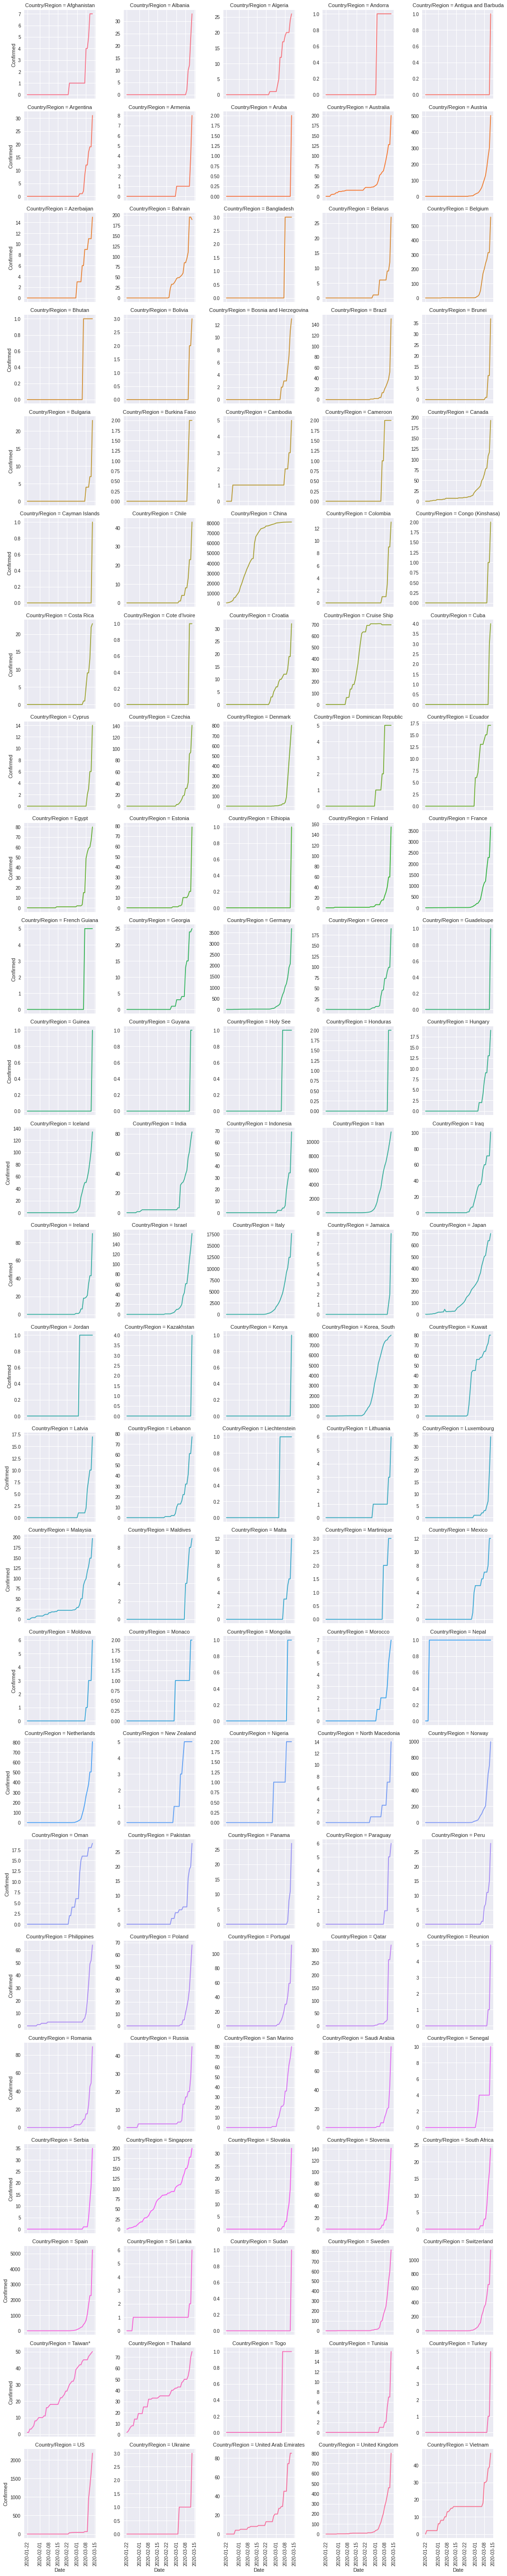

In [0]:
temp = full_table.groupby(['Date', 'Country/Region'])['Confirmed'].sum()
temp = temp.reset_index().sort_values(by=['Date', 'Country/Region'])

plt.style.use('seaborn')
g = sns.FacetGrid(temp, col="Country/Region", hue="Country/Region", 
                  sharey=False, col_wrap=5)
g = g.map(plt.plot, "Date", "Confirmed")
g.set_xticklabels(rotation=90)
plt.show()

New Cases

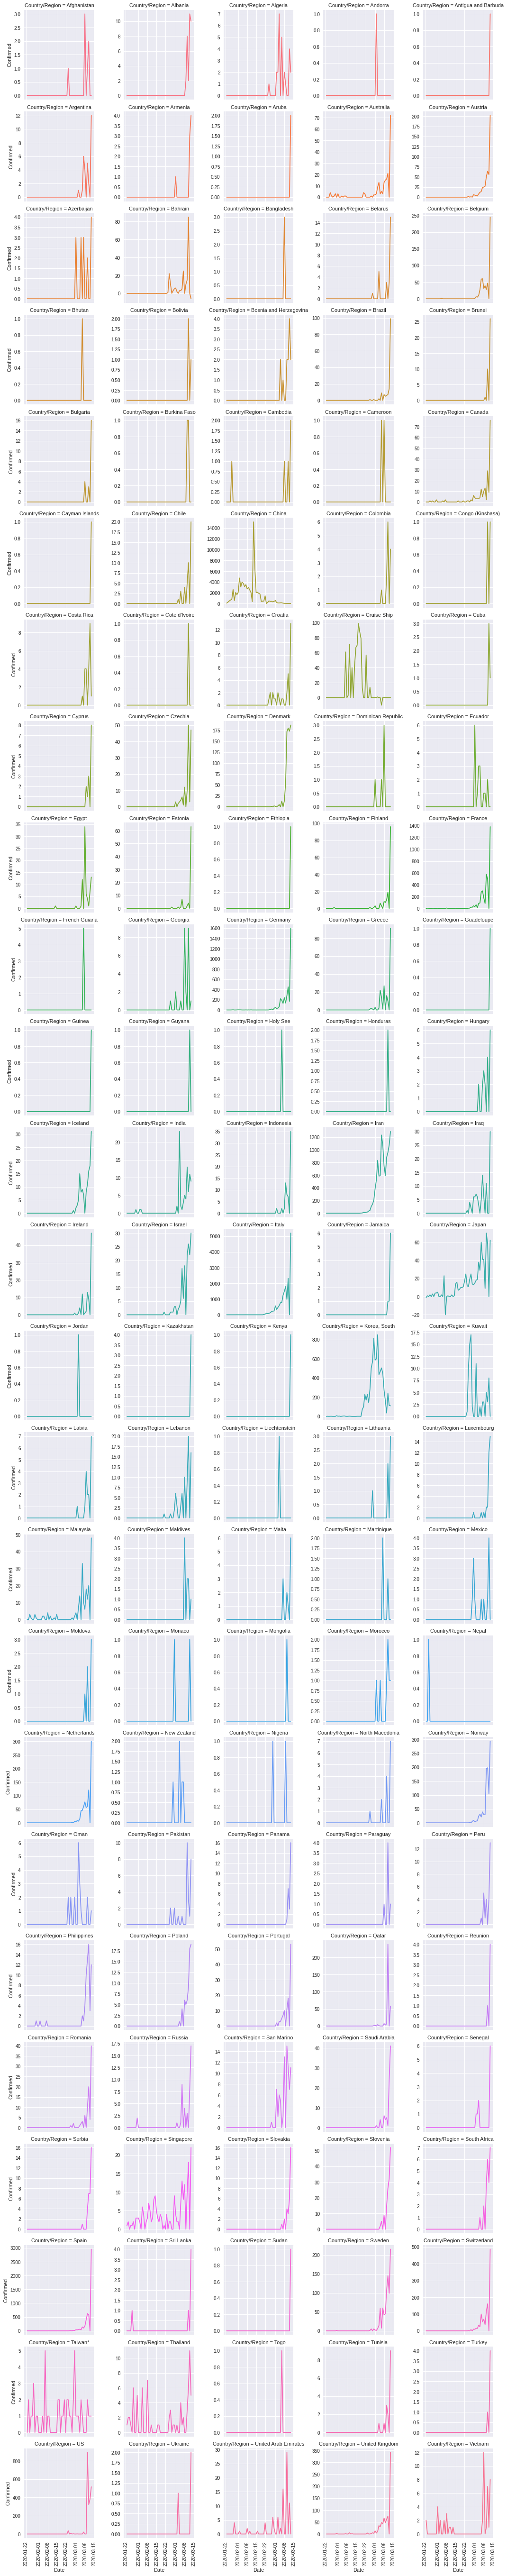

In [0]:
temp = full_table.groupby(['Country/Region', 'Date',])['Confirmed','Deaths','Recovered']
temp = temp.sum().diff().reset_index()

mask = temp['Country/Region'] != temp['Country/Region'].shift(1)

temp.loc[mask,'Confirmed'] = np.nan
temp.loc[mask,'Deaths'] = np.nan
temp.loc[mask,'Recovered'] = np.nan

plt.style.use('seaborn')
g = sns.FacetGrid(temp, col='Country/Region', hue='Country/Region', sharey=False, col_wrap=5)
g = g.map(sns.lineplot, 'Date', 'Confirmed')
g.set_xticklabels(rotation=90)
plt.show()

# Calender Map

Number of new cases every day

ERROR! Session/line number was not unique in database. History logging moved to new session 68


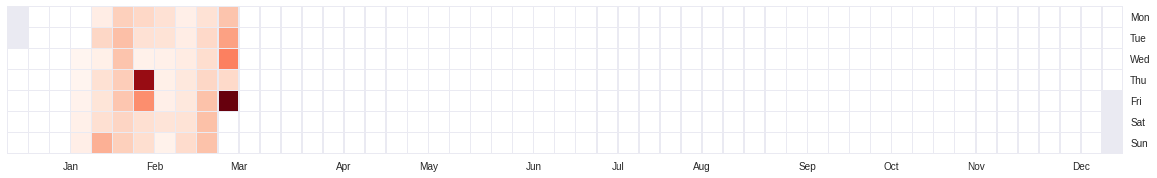

In [0]:
temp = full_table.groupby('Date')['Confirmed'].sum()
temp = temp.diff()
plt.figure(figsize=(20,5))
ax = calmap.yearplot(temp,fillcolor='white', cmap='Reds', linewidth=0.5)

Number of new countries every day

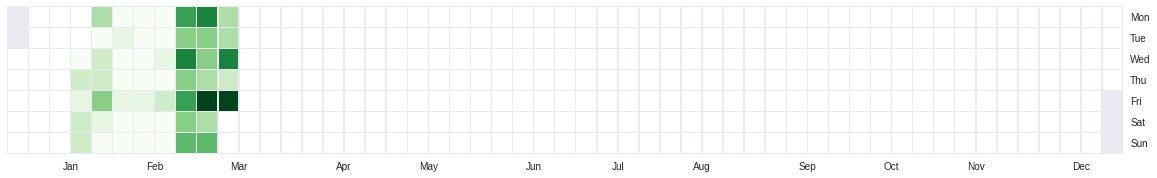

In [0]:
spread = full_table[full_table['Confirmed']!=0].groupby('Date')
spread = spread['Country/Region'].unique().apply(len).diff()
plt.figure(figsize=(20,5))
ax = calmap.yearplot(spread, fillcolor='white', cmap='Greens', linewidth=0.5)

# Comparing with similar epidemics

In [0]:
epidemics = pd.DataFrame({
    'epidemic' : ['COVID-19', 'SARS', 'EBOLA', 'MERS', 'H1N1'],
    'start_year' : [2019, 2003, 2014, 2012, 2009],
    'end_year' : [2020, 2004, 2016, 2017, 2010],
    'confirmed' : [full_latest['Confirmed'].sum(), 8096, 28646, 2494, 6724149],
    'deaths' : [full_latest['Deaths'].sum(), 774, 11323, 858, 19654]
})

epidemics['mortality'] = round((epidemics['deaths']/epidemics['confirmed'])*100,2)
epidemics.head()

epidemic  start_year  end_year  confirmed  deaths  mortality
0  COVID-19        2019      2020     145193    5404       3.72
1      SARS        2003      2004       8096     774       9.56
2     EBOLA        2014      2016      28646   11323      39.53
3      MERS        2012      2017       2494     858      34.40
4      H1N1        2009      2010    6724149   19654       0.29

In [0]:
temp = epidemics.melt(id_vars='epidemic', value_vars=['confirmed', 'deaths', 'mortality'],
                      var_name='Case', value_name='Value')

fig = px.bar(temp, x="epidemic", y="Value", color='epidemic', text='Value', facet_col="Case",
             color_discrete_sequence = px.colors.qualitative.Bold)
fig.update_traces(textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_yaxes(showticklabels=False)
fig.layout.yaxis2.update(matches=None)
fig.layout.yaxis3.update(matches=None)
fig.show()

# Thank you for watching, please subscri